# Run Random Forest

In [5]:
import dis
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import missingno as msno # For visualizing missing values
%matplotlib inline

# Import necessary libraries
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from functools import reduce
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from nfi_wrangling import *

In [66]:
# Load NFI Data
nfi_data = pd.read_csv(
    "../00_process_nfi_data/20231108-211512_nfi_dataset_for_analysis copy.csv",
    index_col=[0],
)

# Load GEE Data
gee_data = pd.read_feather("../02_process_gee_data/final_gee_predictor_dataset.feather")

# print("_" * 120)
# print("NFI:")
# display(nfi_data)
# print("_" * 120)
# print("GEE:")
# display(gee_data)

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_5703/1165322696.py:2: DtypeWarning: Columns (51,58,61,73,74,75,88,89,90,91,106,107,112,113,115,119,125,127,156) have mixed types. Specify dtype option on import or set low_memory=False.
  nfi_data = pd.read_csv(


In [67]:
# Calculate growth and mortality at the plot-level
# ⚠️  This cell takes about 1 minute to run, so loading the data from the feather file instead
#     Plus, for some reason, after running this cell, the notebook slows down massively.

# grouped = nfi_data.groupby("idp", as_index=False)
# df_list = [group for name, group in grouped]

# out = run_mp(
#     calculate_growth_mortality,
#     df_list,
#     combine_func=pd.concat,
#     progress_bar=True,
#     num_cores=10,
# )

# out.to_feather("nfi-idp_level_aggregated_-growth_mortality.feather")

out = pd.read_feather("nfi-idp_level_aggregated_-growth_mortality.feather")
out.head(2)

,idp,n_ini,n_sur,n_fin,ba_at_v1_of_alive_trees,ba_at_v2_of_alive_trees,ba_at_v1_of_survivors,ba_at_v2_of_survivors,ba_at_v2_of_dead,n_mor_yr_esq,...,n_rec_yr,ba_loss_yr,ba_gain_yr,ba_ingr_yr,ba_growth_abs,ba_growth_rate,ba_loss_abs,ba_loss_rate,ba_change_abs,ba_change_rel
0,500002,10,10,10,88.080937,94.781104,88.080937,94.781104,0.0,0.0,...,0.0,0.0,1.466279,1.466279,1.340033,1.521366,0.0,0.0,77.164917,0.175214
0,500008,7,7,7,3.856284,5.790708,3.856284,5.790708,0.0,0.0,...,0.0,0.0,8.131010,8.131010,0.386885,10.032580,0.0,0.0,5.019451,0.260326


In [143]:
# Attach nfi data back again
# df_tmp = out.merge(nfi_data, on="idp", how="left")

# Attach gee data
df_tmp = out.merge(gee_data, on="idp", how="left")

In [144]:
df_tmp.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38696 entries, 0 to 38695
Data columns (total 150 columns):
 #    Column                                        Dtype  
---   ------                                        -----  
 0    idp                                           int64  
 1    n_ini                                         int64  
 2    n_sur                                         int64  
 3    n_fin                                         int64  
 4    ba_at_v1_of_alive_trees                       float64
 5    ba_at_v2_of_alive_trees                       float64
 6    ba_at_v1_of_survivors                         float64
 7    ba_at_v2_of_survivors                         float64
 8    ba_at_v2_of_dead                              float64
 9    n_mor_yr_esq                                  float64
 10   n_mor_yr                                      float64
 11   n_rec_yr                                      float64
 12   ba_loss_yr                                  

In [145]:
# Define the target variable
my_target_variable = "ba_loss_rate"
target = my_target_variable
test_split = 0.2
seed_nr = 42
na_drop_threshold = 0.8

<Axes: >

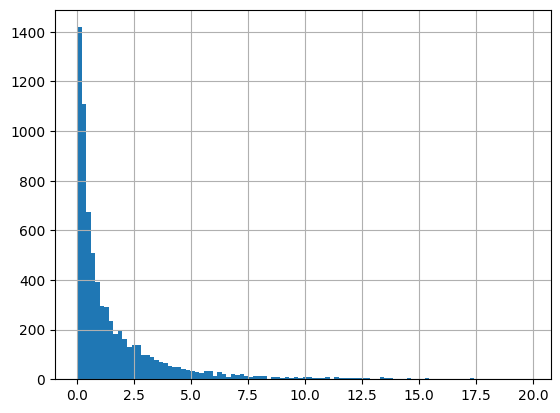

In [146]:
# DROP ROWS
# Drop zero values from target (holds no information)
df_for_rf = df_tmp
df_for_rf = df_for_rf[df_tmp[target] != 0]
df_for_rf.ba_loss_rate.hist(bins=100)

In [147]:
# DROP COLUMNS

# Remove variables with more than set percentage of NA
cols_before_removing_na = df_for_rf.shape[1]
df_for_rf = df_for_rf.dropna(axis=1, thresh=int(na_drop_threshold * len(df_for_rf)))
cols_after_removing_na = df_for_rf.shape[1]
print(
    f"NA threshold of {na_drop_threshold} removed",
    cols_before_removing_na - cols_after_removing_na,
    "columns",
)

# Remove unwanted columns
df_for_rf = df_for_rf.drop(columns=["idp", "tree_id"], errors="ignore")  # Plot id

df_for_rf = df_for_rf.drop(
    columns=out.drop(columns=my_target_variable).columns, errors="ignore"
)  # errors = ignore, if the column doesn't exist, don't throw an error

# Keep only numerical or float columns
df_for_rf = df_for_rf.select_dtypes(include=["float64", "int64"])

# Replace NaNs with column mean
df_for_rf = df_for_rf.fillna(df_for_rf.mean()) # TODO Not sure if this is the best way to replace NA values!

NA threshold of 0.8 removed 18 columns


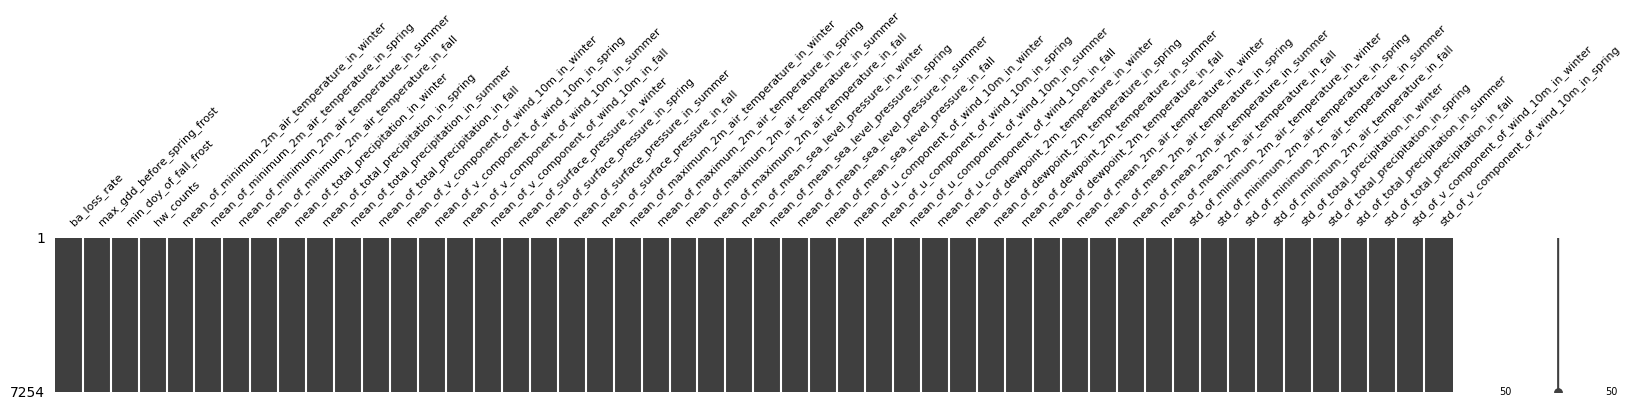

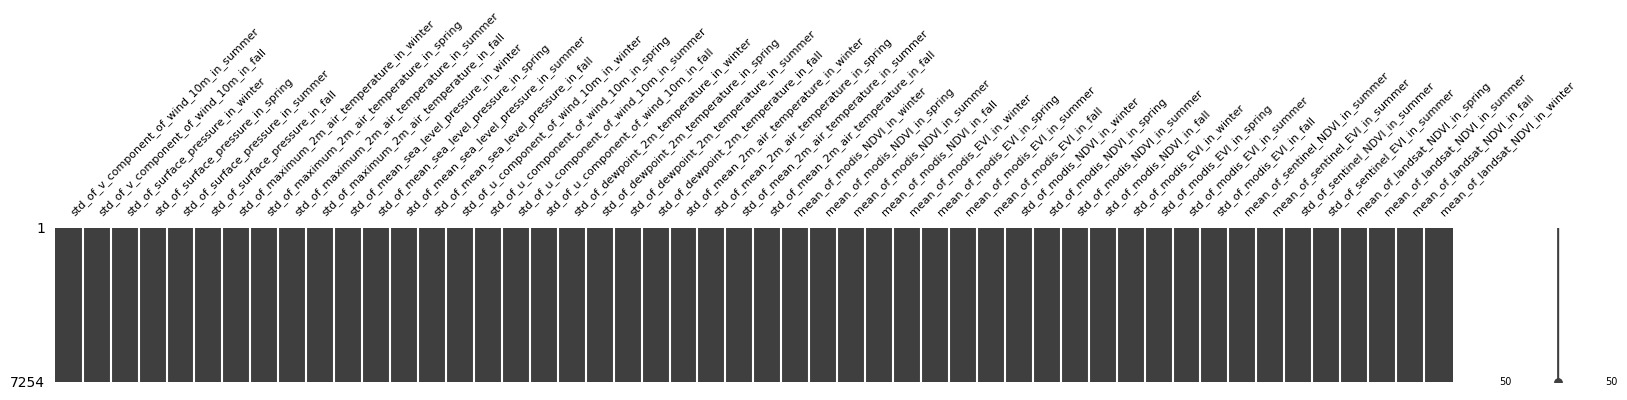

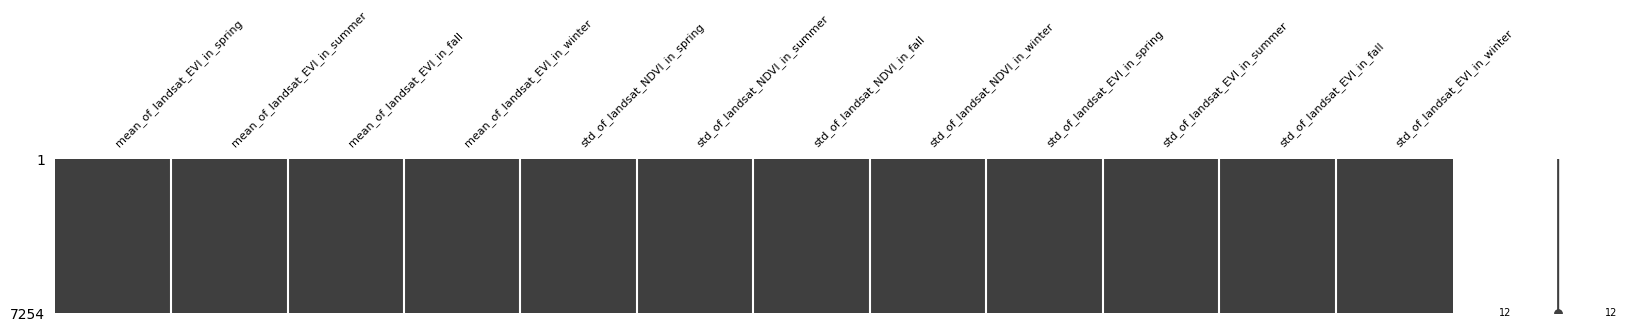

In [148]:
for i in range(0, len(df_for_rf.columns), 50):
    msno.matrix(df_for_rf.iloc[:, i : i + 50], figsize=(20, 2), fontsize=8)

In [149]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_for_rf.drop(target, axis=1),
    df_for_rf[target],
    test_size=test_split,
    random_state=seed_nr,
)

In [150]:
# Cell takes ~5 minutes to run...

# Create a Random Forest Regressor object
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [10, 50, 100, 500],
    "max_depth": [5, 15],  # [5, 10, 15, 20],
    # "min_samples_split": [2, 5],  # [2, 5, 10],
    # "min_samples_leaf": [2, 4],  # [1, 2, 4],
    "max_features": ["auto"],  # ["auto", "sqrt", "log2"],
}

# Perform Grid Search Cross Validation to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.


In [151]:
# Create a Random Forest Regressor object with the best parameters
# rf_best = RandomForestRegressor(**grid_search.best_params_, random_state=42, n_jobs=-1)
rf_best = RandomForestRegressor(n_estimators=100, random_state=seed_nr, n_jobs=-1)

In [152]:
# Fit the model on the training data
rf_best.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [153]:
# Predict on the test data
y_pred = rf_best.predict(X_test)

# Calculate the evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R2 score: ", r2)
print("RMSE: ", rmse)
print("MAE: ", mae)

R2 score:  -0.05965341483737663
RMSE:  2.6433979824308658
MAE:  1.7883000285580748


,Feature,Importance
0,std_of_modis_EVI_in_winter,0.023152
1,std_of_sentinel_NDVI_in_summer,0.017665
2,std_of_modis_EVI_in_fall,0.017524
3,std_of_modis_EVI_in_summer,0.017221
4,std_of_sentinel_EVI_in_summer,0.017196
5,std_of_modis_NDVI_in_winter,0.016555
6,mean_of_sentinel_EVI_in_summer,0.015984
7,mean_of_modis_EVI_in_spring,0.015649
8,mean_of_modis_NDVI_in_winter,0.015614
9,mean_of_modis_NDVI_in_spring,0.015278


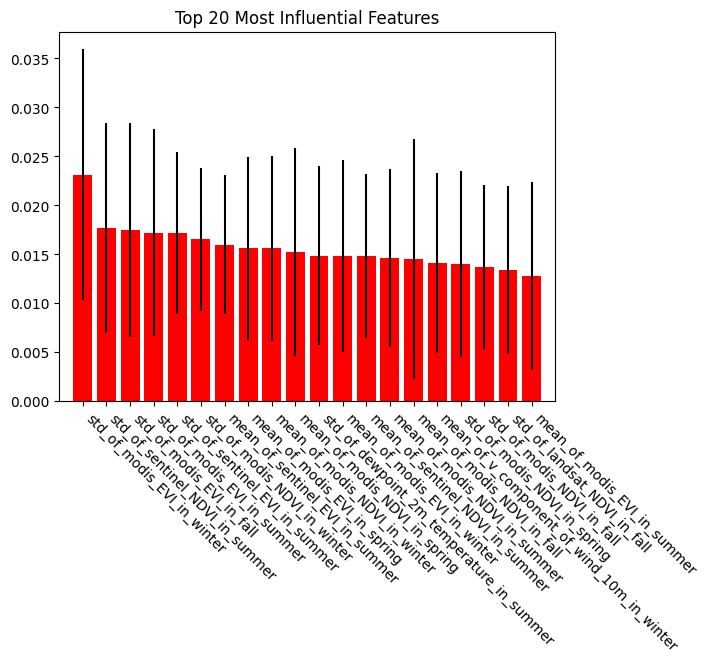

In [154]:
# Plot the variable importance
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]  # only top 20 features

plt.figure()
plt.title("Top 20 Most Influential Features")
plt.bar(
    range(20),  # only top 20 features
    importances[indices],
    color="r",
    yerr=std[indices],
    align="center",
)

# Convert X_train to a pandas dataframe
X_train_df = pd.DataFrame(X_train)

plt.xticks(
    range(20), X_train_df.columns[indices], rotation=315, ha="left"
)  # only top 20 features
plt.xlim([-1, 20])  # only top 20 features


top_20 = pd.DataFrame(
    {
        "Feature": X_train_df.columns[indices][:20],
        "Importance": importances[indices][:20],
    }
)
top_20

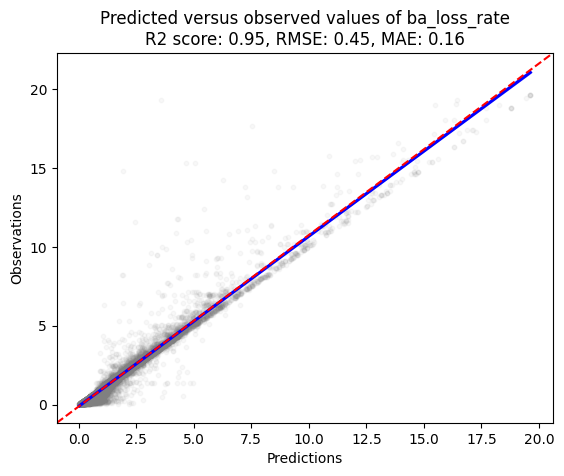

In [ ]:
import seaborn as sns

# Plot the predicted against true values
sns.regplot(
    x=y_pred,
    y=y_test,
    scatter_kws=dict(color="gray", s=10, alpha=0.05),
    line_kws=dict(color="blue"),
)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red")
plt.ylabel("Observations")
plt.xlabel("Predictions")
plt.title(
    f"Predicted versus observed values of {target}\nR2 score: {round(r2, 2)}, RMSE: {round(rmse, 2)}, MAE: {round(mae, 2)}"
)
plt.show()